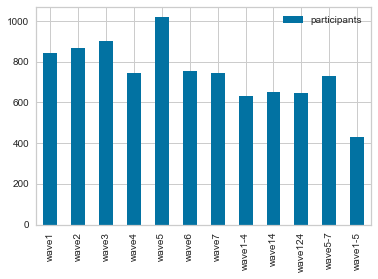

In [33]:
#Steps 1-3
import numpy as np
import pandas as pd
import pandas_profiling as pp
from IPython.display import display, HTML
import pymannkendall as mk
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, cross_validate, cross_val_predict
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import KFold, cross_val_score
from itertools import combinations
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
import ipynb.fs.full.script
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statistics import *

%matplotlib inline
pd.options.display.max_columns = None

pd.options.display.max_rows = 10
pd.options.display.width = 200
np.set_printoptions(precision = 4, suppress = True) 

legit_classes1 = [67,71,72,74,77,78,79,81,83,86,100,101,103,121,122,125,126,127,129,130,131,133,135,138]
legit_classes2 = [73,74,78,81,82,86,100,103,124,125,131,133,135,141,250,251,256,258,259,261,262,263,272,273,277,279,290,291,292,296,297,298,299,300,301,302,303,304,305,306,307,308,310]
participants = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/8. Metadata/Participant_Info.csv", sep= ';')

par_w1 = participants["W1"] == 1
par_w2 = participants["W2"] == 1
par_w3 = participants["W3"] == 1
par_w4 = participants["W4"] == 1
par_w5 = participants["W5"] == 1
par_w6 = participants["W6"] == 1
par_w7 = participants["W7"] == 1

total1 = len(participants[par_w1])
total2 = len(participants[par_w3])
total3 = len(participants[par_w2])
total4 = len(participants[par_w4])
total5 = len(participants[par_w5])
total6 = len(participants[par_w6])
total7 = len(participants[par_w7])
total1_4 = len(participants[par_w1 & par_w2 & par_w3 & par_w4])
total14 = len(participants[par_w1 & par_w4])
total124 = len(participants[par_w1 & par_w2 & par_w4])
total5_7 = len(participants[par_w5 & par_w6 & par_w7])
total1_5 = len(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5])

par_per_wave = pd.DataFrame({
    'participants': [total1, total2, total3, total4, total5, total6, total7, total1_4, total14, total124, total5_7, total1_5]}, index=['wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'wave6', 'wave7', 'wave1-4', 'wave14','wave124', 'wave5-7', 'wave1-5'])

par_per_wave.plot.bar()


#display(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5 & par_w6 & par_w7])
#print(participants[par_w1 & par_w2 & par_w3 & par_w4].count)

In [2]:
#getting participants from 1 to 3
participants1_3 = participants[['Child','Class_Y1']][par_w1 & par_w2 & par_w3]
participants1_3 = participants1_3[participants1_3["Class_Y1"].isin(legit_classes1)]
par_13 = participants1_3
participants1_3 = participants1_3["Child"].tolist()
schools = participants['School'][participants['Child'].isin(participants1_3)].unique().tolist()
display(schools)

[25, 26, 27, 29, 28, 30, 32, 33, 34, 37, 39, 42, 40]

In [3]:
#fit
#compare waves with eachother as percentage for example
fit_clean = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/5. Fitbit data/Fitbit_W17_cleaned_imputation.csv", sep= ';')
fit_clean1_3 = fit_clean[fit_clean["Child"].isin(participants1_3)]

fit_clean1_3 = fit_clean1_3[fit_clean1_3["Wave"] <= 3]

fit_clean1_3 = fit_clean1_3.drop(columns = ['Imputed','Participated'])
fit_clean1_3 = fit_clean1_3.sort_values(['Child','Wave', 'Day'])
display(fit_clean1_3[fit_clean1_3['Child'] == 1222])

,School,Class,Child,Sex,Age,Wave,Day,Date,Steps,Minutes_MVPA
1726,25,67,1222,1,11.0,1,1,28-1-2016,12620.0,0.0
1727,25,67,1222,1,11.0,1,2,29-1-2016,4601.0,0.0
1728,25,67,1222,1,11.0,1,3,30-1-2016,3498.0,0.0
1729,25,67,1222,1,12.0,2,1,31-3-2016,7554.0,17.0
1730,25,67,1222,1,12.0,2,2,1-4-2016,6924.0,13.0
1731,25,67,1222,1,12.0,2,3,2-4-2016,3665.0,0.0
1734,25,67,1222,1,12.0,3,1,1-6-2016,8011.0,10.0
1733,25,67,1222,1,12.0,3,2,2-6-2016,1702.0,0.0
1732,25,67,1222,1,12.0,3,3,3-6-2016,2845.0,0.0


In [4]:
# get the average amount of steps per child over wave 1-3
avg_steps_13 = fit_clean1_3[['School', 'Class', 'Child', 'Wave','Day','Steps']].copy()
avg_steps_13 = avg_steps_13.groupby('Child').mean()
avg_steps_13 = avg_steps_13.drop(columns = ['Wave', 'Day', 'Class', 'School'])
avg_steps_13.reset_index()

full_table_13 = avg_steps_13
full_table_13 = full_table_13.reset_index()
temp = fit_clean1_3.drop(columns = ['Steps', 'Date', 'Minutes_MVPA', 'Day', 'Wave'])
temp = temp.drop_duplicates(subset = ["Child"])

full_table_13 = full_table_13.merge(temp)
full_table_13

,Child,Steps,School,Class,Sex,Age
0,1222,5713.333333,25,67,1,11.0
1,1224,9023.214286,25,67,1,12.0
2,1225,12045.866667,25,67,0,11.0
3,1226,10326.142857,25,67,1,11.0
4,1227,6786.500000,25,67,1,12.0
...,...,...,...,...,...,...
355,3188,13416.769231,40,135,0,10.0
356,3189,7533.692308,40,135,1,9.0
357,3190,12713.666667,40,135,1,9.0
358,3191,9271.545455,40,135,1,9.0


In [5]:
#socio
socio_gbl_123 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves123.xlsx", sep= ';')
socio_gbl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves567.xlsx", sep= ';')
socio_lcl_123 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves123.xlsx", sep= ';')
socio_lcl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves567.xlsx", sep= ';')

socio_lcl_123 = socio_lcl_123.rename(columns={"Node": "Child"})
socio_lcl_123 = socio_lcl_123.drop(['Unnamed: 0', 'ClusteringC'], axis = 1)
socio_gbl_123 = socio_gbl_123.drop(['Unnamed: 0'], axis = 1)

#Add socio data to the full table of week 1-3
full_table_13 = full_table_13.merge(socio_lcl_123, how = 'left')
full_table_13 = full_table_13.merge(socio_gbl_123, how = 'left')
display(full_table_13)
children = full_table_13['Child']

,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes
0,1222,5713.333333,25,67,1,11.0,0.024125,0.772727,1.470588,0.238135,1.330065,0.669935,205,18
1,1224,9023.214286,25,67,1,12.0,0.017039,0.772727,1.294118,0.240811,1.330065,0.669935,205,18
2,1225,12045.866667,25,67,0,11.0,0.006038,0.708333,1.058824,0.195491,1.330065,0.669935,205,18
3,1226,10326.142857,25,67,1,11.0,0.021561,0.680000,1.529412,0.179114,1.330065,0.669935,205,18
4,1227,6786.500000,25,67,1,12.0,0.000460,0.680000,1.000000,0.179114,1.330065,0.669935,205,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,3188,13416.769231,40,135,0,10.0,0.011512,0.944444,1.941176,0.247409,1.111111,0.888889,272,18
356,3189,7533.692308,40,135,1,9.0,0.014462,0.944444,1.941176,0.248110,1.111111,0.888889,272,18
357,3190,12713.666667,40,135,1,9.0,0.005054,1.000000,1.764706,0.262937,1.111111,0.888889,272,18
358,3191,9271.545455,40,135,1,9.0,0.016198,1.000000,2.000000,0.262937,1.111111,0.888889,272,18


In [6]:
#questionnaire 
questionnaire_1 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W1_Main_questions.csv", sep= ';')
questionnaire_2 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W2_Main_questions.csv", sep= ';')
questionnaire_3 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W3_Main_questions.csv", sep= ';')
questionnaire_123 = questionnaire_1.merge(questionnaire_2, on = 'Child')
questionnaire_123 = questionnaire_123.merge(questionnaire_3, on = 'Child')
#display(questionnaire_123.filter(regex=("ME_Internet_Game_Exposure_ME_SM.*")))

questionnaire_123 = questionnaire_123[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x', 'PA_motivation_PA_motiv_.intrin2_x','PA_motivation_PA_motiv_.extrin1_x', 
                                       'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']]
temp = questionnaire_2.loc[:, questionnaire_2.columns.str.contains('facili')]
temp['Child'] = ""
temp = questionnaire_2[temp.columns]
temp = temp.set_index('Child')

# Give a 0 or 1 value for each facility wether it is or is not in the enviroment of the child
for index, row in temp.iterrows():
    temp.loc[index,'Bos'] = row.str.contains('Bos').any()
    temp.loc[index,'Park'] = row.str.contains('Park').any()
    temp.loc[index,'Speelplein'] = row.str.contains('Speelplein').any()
    temp.loc[index,'Speeltuin'] = row.str.contains('Speeltuin').any()
    temp.loc[index,'Sportschool'] = row.str.contains('Sportschool').any()
    temp.loc[index,'Sportclub'] = row.str.contains('Sportclub').any()
    temp.loc[index,'Zwembad'] = row.str.contains('Zwembad').any()
    temp.loc[index,'Meer_zee'] = row.str.contains('Meer_zee').any()
    temp.loc[index,'Dansschool'] = row.str.contains('Dansschool').any()
    temp.loc[index,'Sporthal'] = row.str.contains('Sporthal').any()
    temp.loc[index,'Grasveld'] = row.str.contains('Grasveld').any()
    
temp.drop(temp.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]],axis=1,inplace=True)
temp = temp.astype(int)
questionnaire_123 = questionnaire_123[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x','PA_motivation_PA_motiv_.intrin2_x', 
                                       'PA_motivation_PA_motiv_.extrin1_x', 'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 
                                       'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']].dropna()
questionnaire_123 = questionnaire_123.loc[questionnaire_123['Child'].isin(children)]
questionnaire_123.drop_duplicates()


C:\Users\Armin\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Child,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1814,1.0,5.0,4.0,1.0,6.0,2.0,1.0
1,1815,7.0,6.0,1.0,1.0,6.0,4.0,2.0
2,1819,1.0,6.0,4.0,1.0,6.0,3.0,6.0
3,3161,6.0,6.0,6.0,1.0,6.0,3.0,1.0
6,1428,4.0,6.0,1.0,1.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...,...
896,2987,6.0,5.0,1.0,1.0,6.0,3.0,1.0
897,2988,7.0,1.0,1.0,1.0,1.0,8.0,6.0
898,2990,7.0,4.0,1.0,1.0,5.0,5.0,2.0
916,3084,7.0,4.0,1.0,1.0,6.0,4.0,1.0


In [7]:
temp = temp.reset_index()
full_table_13 = full_table_13.merge(temp)

# merge with the barrier question
temp = questionnaire_123
full_table_13 = full_table_13.merge(temp)
display(full_table_13)

full_table_13['PA_Barriers_Resource_place_1'] = full_table_13['PA_Barriers_Resource_place_1'].fillna(method = 'ffill')

,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1222,5713.333333,25,67,1,11.0,0.024125,0.772727,1.470588,0.238135,1.330065,0.669935,205,18,1,1,0,1,1,1,0,1,1,1,1,7.0,5.0,4.0,4.0,4.0,6.0,1.0
1,1224,9023.214286,25,67,1,12.0,0.017039,0.772727,1.294118,0.240811,1.330065,0.669935,205,18,0,1,0,1,0,1,1,0,1,0,1,7.0,6.0,1.0,1.0,6.0,2.0,1.0
2,1225,12045.866667,25,67,0,11.0,0.006038,0.708333,1.058824,0.195491,1.330065,0.669935,205,18,0,1,1,0,1,0,0,1,0,0,1,7.0,3.0,1.0,1.0,5.0,6.0,3.0
3,1226,10326.142857,25,67,1,11.0,0.021561,0.680000,1.529412,0.179114,1.330065,0.669935,205,18,0,1,0,1,0,1,0,1,0,0,1,5.0,6.0,1.0,1.0,6.0,3.0,1.0
4,1227,6786.500000,25,67,1,12.0,0.000460,0.680000,1.000000,0.179114,1.330065,0.669935,205,18,1,0,0,0,0,0,0,1,0,0,0,7.0,6.0,1.0,1.0,6.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,3188,13416.769231,40,135,0,10.0,0.011512,0.944444,1.941176,0.247409,1.111111,0.888889,272,18,0,0,0,1,1,1,1,0,0,1,1,7.0,6.0,1.0,1.0,6.0,3.0,2.0
284,3189,7533.692308,40,135,1,9.0,0.014462,0.944444,1.941176,0.248110,1.111111,0.888889,272,18,0,1,1,1,1,1,1,0,1,1,1,3.0,6.0,1.0,1.0,6.0,2.0,1.0
285,3190,12713.666667,40,135,1,9.0,0.005054,1.000000,1.764706,0.262937,1.111111,0.888889,272,18,1,0,1,0,0,1,0,0,0,0,1,2.0,4.0,1.0,1.0,6.0,2.0,2.0
286,3191,9271.545455,40,135,1,9.0,0.016198,1.000000,2.000000,0.262937,1.111111,0.888889,272,18,0,1,1,0,0,0,0,0,1,0,1,6.0,6.0,1.0,1.0,6.0,2.0,1.0


In [8]:
copy = full_table_13.drop(columns = ['Child', 'School', 'Class', 'Sex', 'Age', 'Nodes', 'Edges'])

In [9]:
copy.describe()

,Steps,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,10212.179699,0.017020,0.783305,1.465138,0.229347,1.248400,0.719546,0.291667,0.510417,0.625000,0.802083,0.357639,0.447917,0.489583,0.194444,0.288194,0.475694,0.798611,5.673611,5.173611,1.420139,1.500000,5.569444,4.003472,1.895833
std,2975.838612,0.019000,0.106257,0.330268,0.050302,0.141736,0.114683,0.455321,0.500762,0.484966,0.399123,0.480139,0.498146,0.500762,0.396461,0.453710,0.500278,0.401736,1.856638,1.270572,1.150917,1.221184,1.009728,1.829869,1.466080
min,5049.000000,0.000000,0.489815,0.375000,0.072627,0.911765,0.458333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8075.571678,0.005054,0.703704,1.228632,0.197134,1.127273,0.650000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,5.000000,1.000000,1.000000,6.000000,3.000000,1.000000
50%,9924.742424,0.010421,0.769231,1.526316,0.225443,1.219780,0.708791,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,6.000000,1.000000,1.000000,6.000000,4.000000,1.000000
75%,12021.680556,0.021249,0.852071,1.733333,0.262521,1.347953,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,7.000000,6.000000,1.000000,1.000000,6.000000,5.000000,2.000000
max,20265.785714,0.113519,1.000000,2.000000,0.423749,1.518333,0.902778,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,6.000000,6.000000,6.000000,6.000000,9.000000,6.000000


In [10]:
#classify the participants based on the amount of PA they display on average
temp = copy[['Steps']]

temp.loc[(temp['Steps'] < 10000), 'Steps_class'] = 0
temp.loc[(temp['Steps'] > 11700), 'Steps_class'] = 2
temp.loc[(temp['Steps'] > 10000) & (temp['Steps'] < 11700), 'Steps_class'] = 1


copy['Steps_class'] = temp['Steps_class']
temp['Steps_class'].value_counts()

C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:850: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

0.0    148
2.0     82
1.0     58
Name: Steps_class, dtype: int64

C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.232 , 0.175 , 0.1939, 0.2322, 0.208 ]),
 'score_time': array([0.016, 0.018, 0.024, 0.016, 0.024]),
 'estimator': [RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier()],
 'test_accuracy': array([0.569 , 0.5345, 0.569 , 0.5965, 0.4912]),
 'test_precision_weighted': array([0.5722, 0.3845, 0.642 , 0.5939, 0.4709]),
 'test_recall_weighted': array([0.569 , 0.5345, 0.569 , 0.5965, 0.4912]),
 'test_f1_weighted': array([0.5225, 0.435 , 0.5007, 0.5337, 0.4355])}

Features sorted by their score for estimator 0:
                                          importance
Eigenvector                                 0.114803
Betweeness                                  0.110881
Degree                                      0.084195
Closeness                                   0.077913
Avg_Short_Path                              0.072757
Density                                     0.066280
ME_Internet_Game_Exposure_ME_Int_hours_x    0.058025
ME_Internet_Game_Exposure_ME_Int_days_x     0.049059
PA_Barriers_Resource_place_1                0.041948
PA_motivation_PA_motiv_.intrin2_x           0.038676
PA_motivation_PA_motiv_.extrin3_x           0.031090
Sportclub                                   0.024290
Park                                        0.022825
PA_motivation_PA_motiv_.extrin1_x           0.021510
Sportschool                                 0.021374
Speelplein                                  0.021177
Dansschool                                  0.02016

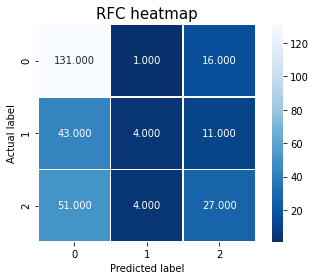

In [11]:
#cross validation default classifier
pd.options.display.max_rows = None
features = copy.drop(columns = ['Steps','Steps_class'])
label = copy['Steps_class']
skf = StratifiedKFold(n_splits=5, random_state = 1, shuffle=True)
rfc = RandomForestClassifier()

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(rfc, features, label, cv=skf, scoring=scoring, return_estimator = True)
predicted = cross_val_predict(rfc, features, label, cv=skf)
display(scores)

s=confusion_matrix(label, predicted)
sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('RFC heatmap', size = 15);

for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = features.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

In [12]:
#Try to find the optimal random forest model
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features, label)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100}

C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.387 , 0.4229, 0.393 , 0.357 , 0.4658]),
 'score_time': array([0.0279, 0.0289, 0.0289, 0.0349, 0.0319]),
 'estimator': [RandomForestClassifier(max_depth=100, max_features='sqrt', min_samples_leaf=4,
                         min_samples_split=5, n_estimators=200),
  RandomForestClassifier(max_depth=100, max_features='sqrt', min_samples_leaf=4,
                         min_samples_split=5, n_estimators=200),
  RandomForestClassifier(max_depth=100, max_features='sqrt', min_samples_leaf=4,
                         min_samples_split=5, n_estimators=200),
  RandomForestClassifier(max_depth=100, max_features='sqrt', min_samples_leaf=4,
                         min_samples_split=5, n_estimators=200),
  RandomForestClassifier(max_depth=100, max_features='sqrt', min_samples_leaf=4,
                         min_samples_split=5, n_estimators=200)],
 'test_accuracy': array([0.5517, 0.5345, 0.6207, 0.5965, 0.4737]),
 'test_precision_weighted': array([0.631 , 0.3931, 0.5088, 0.67

Features sorted by their score for estimator 0:
                                          importance
Eigenvector                                 0.155744
Betweeness                                  0.108708
Degree                                      0.096094
Closeness                                   0.091333
Density                                     0.067388
Avg_Short_Path                              0.060030
ME_Internet_Game_Exposure_ME_Int_hours_x    0.057069
PA_Barriers_Resource_place_1                0.050273
ME_Internet_Game_Exposure_ME_Int_days_x     0.039266
PA_motivation_PA_motiv_.intrin2_x           0.035788
Sportclub                                   0.030904
Dansschool                                  0.024188
PA_motivation_PA_motiv_.extrin3_x           0.022889
Sportschool                                 0.020585
Park                                        0.018288
Zwembad                                     0.018165
Sporthal                                    0.01642

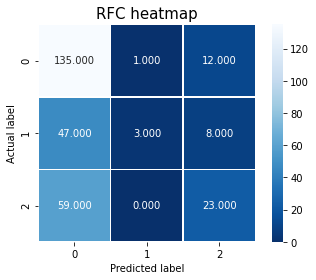

In [13]:
#cross validation optimized classifier
best_random = rf_random.best_estimator_

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(best_random, features, label, cv=skf, scoring=scoring, return_estimator = True)
predicted = cross_val_predict(best_random, features, label, cv=skf)
display(scores)

s=confusion_matrix(label, predicted)
sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('RFC heatmap', size = 15);

for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = features.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

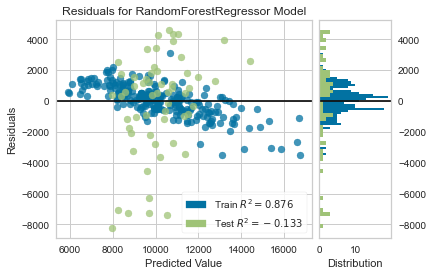

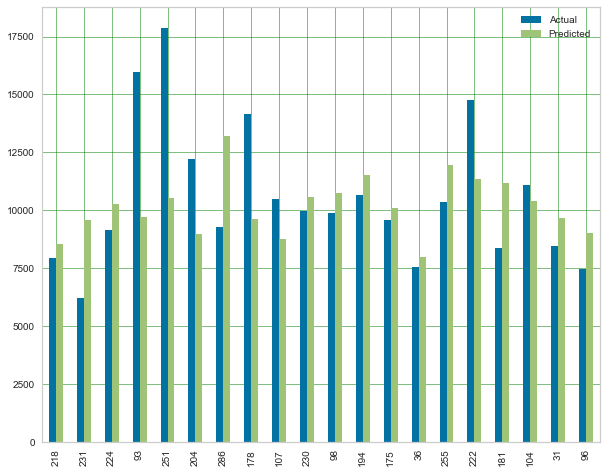

Mean Absolute Error: 2470.4 degrees.
Accuracy: 75.42 %.


In [11]:
# random forest regressor
pd.options.display.max_rows = None
features = copy.drop(columns = ['Steps','Steps_class'])
label_steps = full_table_13['Steps']

rf = RandomForestRegressor()
features_train, features_test, label_train, label_test = train_test_split(features, label_steps, test_size=0.2)

visualizer = ResidualsPlot(rf)
visualizer.fit(features_train, label_train)  # Fit the training data to the visualizer
visualizer.score(features_test, label_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

predictions = visualizer.predict(features_test)
df = pd.DataFrame({'Actual': label_test, 'Predicted': predictions})
df1 = df.head(20)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

errors = abs(predictions - label_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / label_test)

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [34]:
#cross validation default regressor
kf = KFold(n_splits=5, random_state=1, shuffle=True)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error']
scores = cross_validate(rf, features, label_steps, cv=kf, scoring=scoring, return_estimator = True)
predicted = cross_val_predict(rf, features, label_steps, cv=kf)
display(scores)

for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = features.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

{'fit_time': array([0.3531, 0.3022, 0.389 , 0.3211, 0.3142]),
 'score_time': array([0.014 , 0.0219, 0.0269, 0.0209, 0.0209]),
 'estimator': [RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor()],
 'test_neg_mean_absolute_error': array([-2362.3387, -2262.3787, -2523.1804, -2104.5113, -2077.8585]),
 'test_neg_mean_squared_error': array([ -8386780.8035,  -8956513.8972, -10487825.6559,  -7958345.0839,
         -6842378.6398]),
 'test_r2': array([ 0.0137,  0.0945,  0.0228, -0.1399,  0.0723]),
 'test_neg_mean_absolute_percentage_error': array([-0.2879, -0.2487, -0.243 , -0.2253, -0.2108])}

Features sorted by their score for estimator 0:
                                          importance
Betweeness                                  0.185821
Eigenvector                                 0.151008
Density                                     0.082498
ME_Internet_Game_Exposure_ME_Int_hours_x    0.077037
Degree                                      0.076927
...                                              ...
Sportclub                                   0.012974
Speeltuin                                   0.011600
Bos                                         0.011309
Grasveld                                    0.009365
PA_motivation_PA_motiv_.extrin1_x           0.008909

[24 rows x 1 columns]
Features sorted by their score for estimator 1:
             importance
Eigenvector    0.196816
Density        0.108755
Betweeness     0.101841
Closeness      0.088010
Degree         0.082435
...                 ...
Park           0.010496
Zwembad        0.010293
Speelplein     0.010202
Sport

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features, label_steps)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

In [35]:
#cross validation optimized regressor
best_random_2 = rf_random.best_estimator_

scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error']
scores = cross_validate(best_random_2, features, label_steps, cv=kf, scoring=scoring, return_estimator = True, )
predicted = cross_val_predict(best_random_2, features, label_steps, cv=kf)
display(scores)

for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = features.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

{'fit_time': array([1.494 , 1.4371, 1.4012, 1.479 , 1.3983]),
 'score_time': array([0.0818, 0.0788, 0.0808, 0.0768, 0.0708]),
 'estimator': [RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                        n_estimators=800),
  RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                        n_estimators=800),
  RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                        n_estimators=800),
  RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                        n_estimators=800),
  RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                        n_estimators=800)],
 'test_neg_mean_absolute_error': array([-2262.1241, -2186.6509, -2467.2983, -2039.2541, -2009.6725]),
 'test_neg_mean_squared_error': array([ -7463014.63  ,  -8735674.8126, -10042275.8271,  -6857589.9413,
         -6321605.1519]),
 'test_r2': array([0.1223, 0.1168, 0.0643, 0.0178, 0.1429]),
 'test_neg_mean_ab

Features sorted by their score for estimator 0:
             importance
Betweeness     0.138644
Eigenvector    0.122683
Closeness      0.093193
Density        0.091965
Degree         0.086010
...                 ...
Speelplein     0.011919
Speeltuin      0.010888
Zwembad        0.010501
Grasveld       0.010188
Bos            0.009769

[24 rows x 1 columns]
Features sorted by their score for estimator 1:
                importance
Eigenvector       0.152825
Density           0.108238
Betweeness        0.104633
Closeness         0.097220
Avg_Short_Path    0.085422
...                    ...
Meer_zee          0.011813
Park              0.010935
Speelplein        0.010913
Sporthal          0.010901
Speeltuin         0.008092

[24 rows x 1 columns]
Features sorted by their score for estimator 2:
             importance
Betweeness     0.143700
Eigenvector    0.139046
Closeness      0.106926
Degree         0.090563
Density        0.077974
...                 ...
Speelplein     0.010637
Park  